# loadest-gp (prototype)
LOAD ESTimator (LOADEST) is a software program for estimating some constituent using surrogate variables (covariates).
However, LOADEST has several serious limitations, and it has been all but replaced by another model known as WRTDS.
`loadest-gp` essentially reimplements WRTDS as a Gaussian process.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/discontinuum/blob/main/notebooks/loadest-gp-demo.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/thodson-usgs/discontinuum/main?labpath=notebooks%2Floadest-gp-demo.ipynb)

In [43]:
# install the latest version of discontinuum
# !pip install git+https://github.com/thodson-usgs/discontinuum.git
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import xarray as xr

%matplotlib inline

In [57]:
# setup

# SF Coeur D Alene River
site = "12413470"
start_date = "1988-10-01"
end_date = "2021-09-30"

# Choptank River at Greensboro, MD
site = "01491000"
start_date = "1979-10-01"
end_date = "2011-09-30"

characteristic = "Inorganic nitrogen (nitrate and nitrite)"
# characteristic = 'Phosphorus'
fraction = "Dissolved"
# fraction = 'Total'

First, download the data. In `discontinuum`, the convention is to download directly using `providers`, which wrap a data provider's web-service and perform some initial formatting and metadata construction, then return the result as an `xarray.Dataset`. Here, we'll uses the `usgs` provider. If you need data from another source, create a `provider` and ensure the output matches that of the `usgs` provider. Here, we'll download some daily streamflow data to use as our model's input, and some concentration samples as our target. 

In [58]:
from loadest_gp.providers import usgs

# download covariates (daily streamflow)
daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)

# download target (concentration)
samples = usgs.get_samples(
    site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction
)

samples

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/providers/usgs.py:260: UserWarning: Censored values have been removed from the dataset.
  warnings.warn(


<xarray.Dataset> Size: 10kB
Dimensions:        (time: 652)
Coordinates:
  * time           (time) datetime64[ns] 5kB 1979-12-05T10:30:00 ... 2011-04-...
Data variables:
    concentration  (time) float64 5kB 1.4 0.62 1.2 1.2 ... 0.92 1.54 1.39 0.99
Attributes:
    id:         01491000
    name:       CHOPTANK RIVER NEAR GREENSBORO, MD
    latitude:   38.99719444
    longitude:  -75.7858056

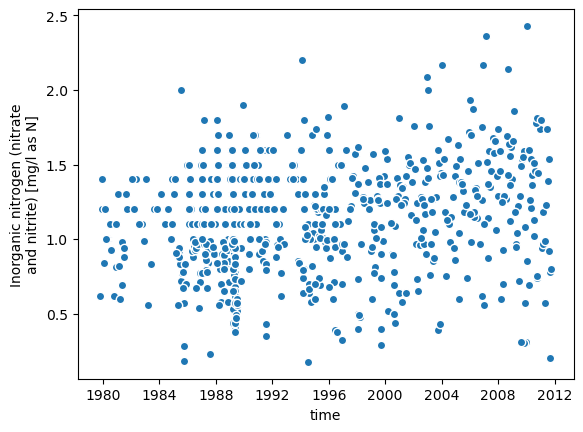

In [59]:
samples.plot.scatter(x="time", y="concentration")

Next, perpare the training data by preforming an inner join of the target and covarites.

In [62]:
from discontinuum.utils import aggregate_to_daily

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join="inner")

Now, we're ready to fit the model. Depending on your hardware, this can take seconds to several minutes. The first fit will also compiles the model, which takes longer. After running it once, try running the cell again and note the difference in wall time.

In [66]:
%%time
# select an engine
# from loadest_gp import LoadestGPMarginalPyMC as LoadestGP
from loadest_gp import LoadestGPMarginalGPyTorch as LoadestGP
from loadest_gp.models.base import ModelConfig

config = ModelConfig(
    transform="standard",
)

model = LoadestGP()

model.fit(target=training_data["concentration"], covariates=training_data[["time", "flow"]])

100%|████████████████████| 100/100 [00:01<00:00, 85.13it/s, loss=1.02]

CPU times: user 2.5 s, sys: 431 ms, total: 2.93 s
Wall time: 1.18 s


<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

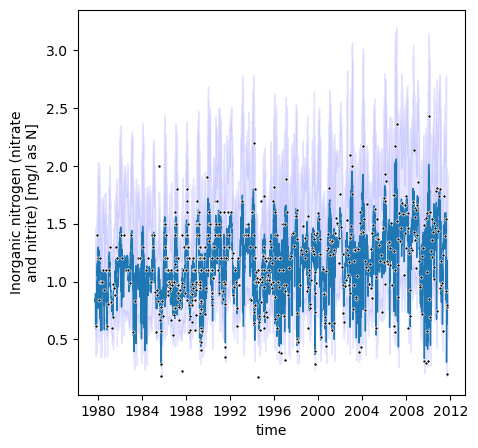

In [67]:
# plot result
model.plot(daily[["time", "flow"]])

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

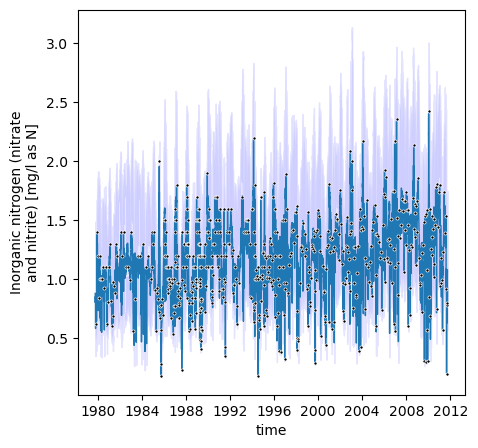

In [65]:
# plot result
model.plot(daily[["time", "flow"]])

Like WRTDS, we can also plot the covariate space:

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


<Axes: xlabel='Year', ylabel='Streamflow [cubic meters per\nsecond]'>

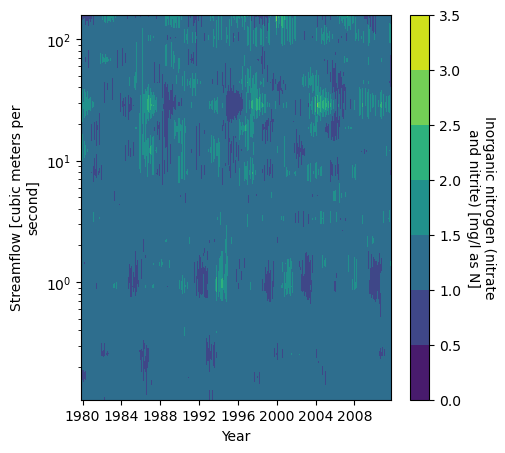

In [16]:
model.contourf(levels=5, y_scale="log")

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


<Axes: xlabel='Year', ylabel='Streamflow [cubic meters per\nsecond]'>

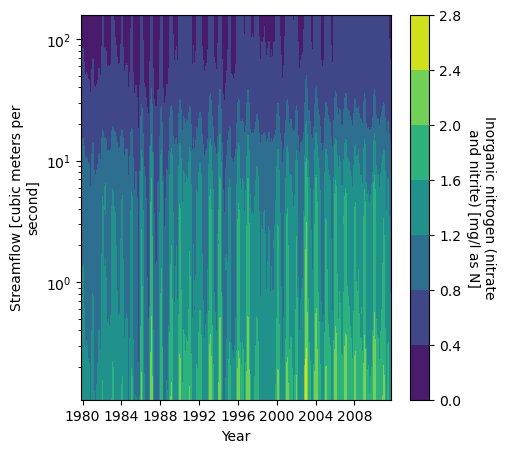

In [37]:
model.contourf(levels=5, y_scale="log")

For plotting, we don't need to simulate the full covariance matrix. Instead, we can use its diagonal to compute confidence intervals, but for most other uses, we need to simulate predictions using full covariance, which is slower. Here, we simulate daily concentration during 1980-2010, then we will use those simulations to estimate annual fluxes with uncertainty.

In [11]:
# simulate concentration
sim_slice = daily[["time", "flow"]].sel(time=slice("1980", "2010"))

sim = model.sample(sim_slice)

In [12]:
sim

<xarray.DataArray (draw: 1000, time: 11323)> Size: 91MB
array([[1.26917765, 1.29484603, 1.3023769 , ..., 1.98057232, 1.96728113,
        1.94716436],
       [1.2020828 , 1.21696328, 1.22613452, ..., 1.88528012, 1.70900962,
        1.80193035],
       [1.32001723, 1.35216942, 1.35280231, ..., 1.88111728, 1.8601322 ,
        1.85666896],
       ...,
       [1.1445452 , 1.11402425, 1.10370514, ..., 1.78288579, 1.69207247,
        1.74433144],
       [1.18352177, 1.21498444, 1.22764335, ..., 1.62945179, 1.63046766,
        1.6489042 ],
       [1.25886449, 1.27362132, 1.26363323, ..., 1.55219113, 1.67340735,
        1.62292142]])
Coordinates:
  * time     (time) datetime64[ns] 91kB 1980-01-01 1980-01-02 ... 2010-12-31
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Attributes:
    pcode:          00631
    standard_name:  concentration
    long_name:      Inorganic nitrogen (nitrate and nitrite)
    units:          mg/l as N
    suffix:         None
    conversion:     1.0

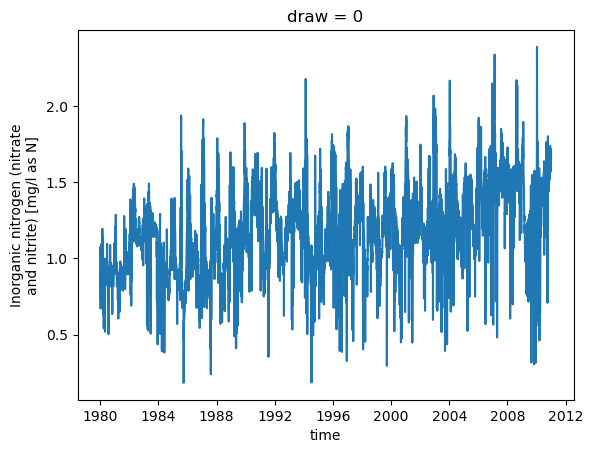

In [39]:
# plot the first realization of concentration.
sim.sel(draw=0).plot.line(x="time")

In practice, we aren't interested in a single simulated timeseries. Rather, we'll take a large sample of these simulated series, then pass them through some function to simulate a probability distrubution. For example, if we were interested in some annual value. We'd pass the simulations through that annual function to estimate a probability distribution. We demonstrate this concent for estimating the annual nutrient flux.

`loadest_gp` provides a couple convenience functions just for this purpose.

<Axes: xlabel='Year', ylabel='Inorganic nitrogen (nitrate and nitrite)\n[kilograms per year]'>

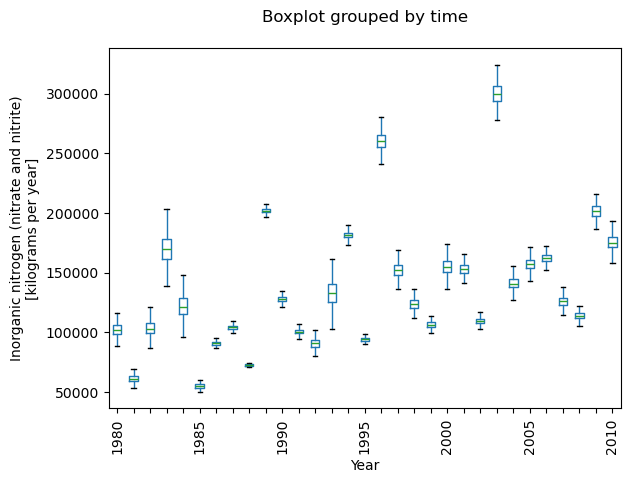

In [13]:
from loadest_gp.utils import concentration_to_flux, plot_annual_flux

flux = concentration_to_flux(sim, sim_slice["flow"])
plot_annual_flux(flux)

In most streams, flow varies substantially from year-to-year, 
and we'd like to know what the flux might have been had flow been constant. 
In causal paralance, this is refered to as a [counterfactual](https://en.wikipedia.org/wiki/Counterfactual_conditional). 
However,`loadest_gp` isn't a causal model and can't provide us with counterfactuals. 
In other words, it can interpolate but not extrapolate. 
Nevertheless, we may treat is as such causal model and see what happens.
Think of this type of analysis as a pseudo-counterfactual or educated guessing.
There area variety of strategies that we might employee, 
some more sophisticated then others. 
At the end of the day, remember we're only guessing, 
so keep it simple and don't be tempted into over-interpretation.
Here, we'll use a simple time substitution.
Pick one year's worth of data and repeat it (except for the time variable) over the entire period of analysis.
For example, let's repeat the year 1995 to fill in the data for our 1980-2010 in our counterfactual.
What's special about 1995?
Nothing, except that it is at the middle of our period.
Choosing a different year should give similar results.

In [14]:
# create the pseudo-counterfactual
from discontinuum.utils import time_substitution

counterfactual = time_substitution(sim_slice, interval=slice("1995", "1995"))

In [15]:
# simulate
counterfactual_sim = model.sample(counterfactual)
counterfactual_flux = concentration_to_flux(counterfactual_sim, sim_slice["flow"])

<Axes: xlabel='Year', ylabel='Inorganic nitrogen (nitrate and nitrite)\n[kilograms per year]'>

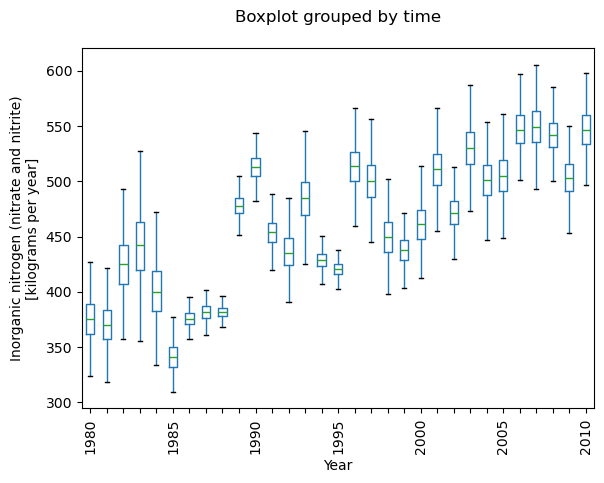

In [16]:
# and plot the result
plot_annual_flux(counterfactual_sim)

Now, the annual fluxes should be less variable than before, and the trend becomes apparent (depending on your choice of river).